# Data Preparation

In this notebook, the downloaded data is inspected during an exploratory data
analysis (EDA). Subsequently, it is prepared so it can be used for training a 
machine learning model.

Potentially, useful parts of several data sets will be integrated here.

The model is supposed to be usable as a service as opposed to a pure research
project, since one of the requirements of this exercise is to deploy it.
Because of that, I want the features to be activels choosable by the users.
However, specific features related to demographics or health such as age or sex
may also have an influence on sleep quality, and must be considered as well.

The goal of this project is to provide a service allowing a user to submit
information about their demographics, health and daily activities and receive a
prediction of the quality of their sleep for the coming night based on
influencable decisions.

Factors like fraction of light or REM sleep are not direct choices by the users,
but typically rather outcomes or consequences of their decisions in a similar
manner as the sleep quality itself. Because of that, they will not be considered
features in this project.

In contrast, factors like daily consumption of caffeine, nicotine, alcohol or
levels of physical activity and study or work typically vary on a day to day 
basis and are more directly subjected to individual decisions made by the users.
Because of that, these variables are of interest in this project, and will be
considered features.

On top of that, features ideally need to be relevant to a large fraction of
users. For example, one of the data sets has a feature `University_Year`.
I still need to decide if I will consider this, as not all users may be students
. In contrast to that, `Study_Hours` may be considered of similar of equal
nature as general work hours, and screen times should apply to close to all
users as well.

Disclaimer: Unfortunately, all the available data sets are synthetically
generated and may not necessarily reflect true causes or patterns in sleep
quality.

## Preparations

In [28]:

# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler

# paths
PATH_DATA_DIR = Path("../data/raw")
PATH_DATA_INTERMEDIATE_DIR = Path("../data/intermediate")
PATH_DATA_PROCESSED_DIR = Path("../data/processed")
PATH_STUDENT_SLEEP_PATTERNS = PATH_DATA_DIR / "student_sleep_patterns.csv"
PATH_WEARABLE_TECH_SLEEP_QUALITY = PATH_DATA_DIR / "wearable_tech_sleep_quality_1.csv"
PATH_SLEEP_EFFICIENCY = PATH_DATA_DIR / "Sleep_Efficiency.csv"
PATH_SLEEP_HEALTH_AND_LIFESTYLE = PATH_DATA_DIR / "Sleep_health_and_lifestyle_dataset.csv"

In [29]:
# functions

def read_csv_cols_lower_underscore(path: Path) -> pd.DataFrame:
    """Read a CSV file and return a DataFrame with column names in lowercase
    and whitespace characters replaced by underscores.
    
    Args:
        path (Path): Path to the CSV file.
    
    Returns:
        pd.DataFrame: DataFrame with column names in lowercase and whitespace
        characters replaced by underscores.
    """
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ", "_")
    return df

## Data set: `student_sleep_patterns.csv`

### Exploratory Data Analysis

In [30]:
# load data set into pandas data frame
df_student_sleep_patterns = read_csv_cols_lower_underscore(PATH_STUDENT_SLEEP_PATTERNS)

df_student_sleep_patterns

,student_id,age,gender,university_year,sleep_duration,study_hours,screen_time,caffeine_intake,physical_activity,sleep_quality,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,24,Male,2nd Year,5.1,9.3,1.9,4,110,4,17.42,8.43,6.93,10.78
496,497,20,Male,2nd Year,8.9,7.7,3.5,3,40,4,1.22,15.54,5.85,7.23
497,498,21,Male,3rd Year,5.7,6.4,3.9,1,68,10,9.94,2.25,5.46,10.72
498,499,18,Female,2nd Year,4.9,0.5,3.5,0,12,2,19.10,15.49,8.35,7.20


### Suitable Features

These features match the criteria, because they can easily be influenced or 
may have an influence on sleep quality and are not outcomes themselves.

- age
- gender
- university_year
- study_hours
- screen_time
- caffeine_intake
- physical_activity
- weekday_sleep_start
- weekend_sleep_start
- weekday_sleep_end
- weekend_sleep_end

Explanation for sleep start and end features: These are the times the student
**typically** goes to sleep. They may represent some habits. It may have an
influence on the quality of your sleep if you stick to them.

### Label

This is the characteristic to predict based on the features.

- sleep_quality

### Unsuitable Features

While some of these features may indeed influence the quality of sleep, they
are not decisions one can always make **before** going to bed.

- student_id: No information about sleep. It's often good practice to still keep
IDs during data processing and dropping them just before training. I will
remove them right here though, because all the data sets are synthetic anyway
and the IDs are ascending numbers. Beyond the fact that they don't provide any
insight, they won't be unique after joining the data sets.

- sleep_duration: If you have deep sleep, you may decide for how long you will
stay in bed, but if your sleep is bad, you may not be able to influence this at
all. In fact it is often the opposite. Potential users may be enriched in people
having sleep problems. They will try to improve sleep quality and get a full
night of rest. Many people cannot just decide to sleep for x amount of hours.

In [31]:
# select relevant features
df_student_sleep_patterns_selected = df_student_sleep_patterns[
    [
        "age",
        "gender",
        "university_year",
        "study_hours",
        "screen_time",
        "caffeine_intake",
        "physical_activity",
        "weekday_sleep_start",
        "weekend_sleep_start",
        "weekday_sleep_end",
        "weekend_sleep_end",
        "sleep_quality",
    ]
]

df_student_sleep_patterns_selected

,age,gender,university_year,study_hours,screen_time,caffeine_intake,physical_activity,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end,sleep_quality
0,24,Other,2nd Year,7.9,3.4,2,37,14.16,4.05,7.41,7.06,10
1,21,Male,1st Year,6.0,1.9,5,74,8.73,7.10,8.21,10.21,2
2,22,Male,4th Year,6.7,3.9,5,53,20.00,20.47,6.88,10.92,5
3,24,Other,4th Year,8.6,2.8,4,55,19.82,4.08,6.69,9.42,9
4,20,Male,4th Year,2.7,2.7,0,85,20.98,6.12,8.98,9.01,3
...,...,...,...,...,...,...,...,...,...,...,...,...
495,24,Male,2nd Year,9.3,1.9,4,110,17.42,8.43,6.93,10.78,4
496,20,Male,2nd Year,7.7,3.5,3,40,1.22,15.54,5.85,7.23,4
497,21,Male,3rd Year,6.4,3.9,1,68,9.94,2.25,5.46,10.72,10
498,18,Female,2nd Year,0.5,3.5,0,12,19.10,15.49,8.35,7.20,2


The data set has 500 rows and 11 meaningful features.
This can serve as the main data set for this project.
500 rows is far from a lot, but from what I have found, this is the most
useful data set.
To make up for the low number of rows / examples, I will try integrating further
data sets.
If that does not turn out to work well, I will just use this main data set only.

In [32]:
# check if the data sets has any missing values
df_student_sleep_patterns_selected.isnull().sum()

age                    0
gender                 0
university_year        0
study_hours            0
screen_time            0
caffeine_intake        0
physical_activity      0
weekday_sleep_start    0
weekend_sleep_start    0
weekday_sleep_end      0
weekend_sleep_end      0
sleep_quality          0
dtype: int64

There are no missing values.

In [33]:
# save this version to the intermediate data directory
# it is already transformed to a certain degree, but not fully processed
df_student_sleep_patterns_selected.to_csv(
    PATH_DATA_INTERMEDIATE_DIR / "sleep_data_main_intermediate.csv",
    index=False
)

## Data set: `wearable_tech_sleep_quality_1.csv`

### Exploratory Data Analysis

In [34]:
# load the data set into a pandas data frame
df_wearable_tech_sleep_quality = read_csv_cols_lower_underscore(PATH_WEARABLE_TECH_SLEEP_QUALITY)

df_wearable_tech_sleep_quality

,heart_rate_variability,body_temperature,movement_during_sleep,sleep_duration_hours,sleep_quality_score,caffeine_intake_mg,stress_level,bedtime_consistency,light_exposure_hours
0,79.934283,37.199678,1.324822,4.638289,1.000000,107.624032,2.771837,0.657037,7.933949
1,67.234714,36.962317,1.855481,6.209422,1.000000,104.658589,3.738138,0.144464,6.992699
2,82.953771,36.529815,1.207580,6.879592,10.000000,0.000000,3.115880,0.642949,7.655250
3,100.460597,36.176532,1.692038,10.331531,1.000000,116.990981,3.904008,0.453255,9.429463
4,65.316933,36.849112,0.106385,8.334830,1.000000,223.282908,4.571699,0.641492,10.555713
...,...,...,...,...,...,...,...,...,...
995,64.377994,37.035075,2.077481,7.542686,1.000000,167.146932,4.404266,0.941971,8.203260
996,105.953731,36.486739,2.257753,4.383282,1.000000,265.264810,6.538063,0.565399,10.334435
997,82.816857,36.059063,0.758239,7.019553,8.445252,28.259621,3.945222,0.332975,11.176894
998,58.576420,36.418467,2.334176,9.965067,1.000000,196.795042,4.989787,0.830583,6.630026


### Suitable Features

- caffeine_intake_mg
- stress_level
- light_exposure_hours

### Label

- sleep_quality_score

### Unsuitable Features

Cannot always be decided by user:
- heart_rate_variability
- body_temperature
- movement_during_sleep
- sleep_duration_hours

Hard to integrate with other data sets:

- bedtime_consistency

In [35]:
# select releant columns
df_wearable_tech_sleep_quality_selected = df_wearable_tech_sleep_quality[
    [
        "caffeine_intake_mg",
        "stress_level",
        "light_exposure_hours",
        "sleep_quality_score"
    ]
]

df_wearable_tech_sleep_quality_selected

,caffeine_intake_mg,stress_level,light_exposure_hours,sleep_quality_score
0,107.624032,2.771837,7.933949,1.000000
1,104.658589,3.738138,6.992699,1.000000
2,0.000000,3.115880,7.655250,10.000000
3,116.990981,3.904008,9.429463,1.000000
4,223.282908,4.571699,10.555713,1.000000
...,...,...,...,...
995,167.146932,4.404266,8.203260,1.000000
996,265.264810,6.538063,10.334435,1.000000
997,28.259621,3.945222,11.176894,8.445252
998,196.795042,4.989787,6.630026,1.000000


In [36]:
# check if the data sets has any missing values
df_wearable_tech_sleep_quality_selected.isnull().sum()

caffeine_intake_mg      0
stress_level            0
light_exposure_hours    0
sleep_quality_score     0
dtype: int64

There are no missing values.

Some of these columns such as caffeine intake [mg] match with the main data set.
Others don't.
If I join / integrate them, I will have to scale the sleep quality score so the
scores from different data sets have a comparable interval.
One option would be normalizing and standardizing them.

This dataset is not bad, but it cannot serve as standalone data for the current
project, so I won't save it to an individual file.

## Data set: `Sleep_Efficiency.csv`

### Exploratory Data Analysis

In [37]:
# load the data set into a pandas data frame
df_sleep_efficiency = read_csv_cols_lower_underscore(PATH_SLEEP_EFFICIENCY)

df_sleep_efficiency.head()

,id,age,gender,bedtime,wakeup_time,sleep_duration,sleep_efficiency,rem_sleep_percentage,deep_sleep_percentage,light_sleep_percentage,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


Features and label are selected as defined previously.

### Suitable Features

- age
- gender
- caffeine_consumption
- alcohol_consumption
- smoking_status
- exercise_frequency

### Label

- sleep_efficiency: Not necessarily the same as sleep quality, but may be
similar enough.

### Unsuitable Features

As previously, you cannot choose this before going to bed.

- id
- sleep_duration
- rem_sleep_percentage
- deep_sleep_percentage
- light_sleep_percentage
- awakenings

These two are kind of similar to main data, but they are not exactly the same.
I won't use the for the integrated version.

- bedtime: indicates when each subject goes to bed each day -> similar to main data
- wakeup_time: indicates when each subject wakes up each day

In [38]:
# select relevant columns
df_sleep_efficiency_selected = df_sleep_efficiency[
    [
        "age",
        "gender",
        "caffeine_consumption",
        "alcohol_consumption",
        "smoking_status",
        "exercise_frequency",
        "bedtime",
        "wakeup_time",
        "sleep_efficiency"
    ]
]

df_sleep_efficiency_selected

,age,gender,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,bedtime,wakeup_time,sleep_efficiency
0,65,Female,0.0,0.0,Yes,3.0,2021-03-06 01:00:00,2021-03-06 07:00:00,0.88
1,69,Male,0.0,3.0,Yes,3.0,2021-12-05 02:00:00,2021-12-05 09:00:00,0.66
2,40,Female,0.0,0.0,No,3.0,2021-05-25 21:30:00,2021-05-25 05:30:00,0.89
3,40,Female,50.0,5.0,Yes,1.0,2021-11-03 02:30:00,2021-11-03 08:30:00,0.51
4,57,Male,0.0,3.0,No,3.0,2021-03-13 01:00:00,2021-03-13 09:00:00,0.76
...,...,...,...,...,...,...,...,...,...
447,27,Female,0.0,0.0,No,5.0,2021-11-13 22:00:00,2021-11-13 05:30:00,0.91
448,52,Male,25.0,0.0,No,3.0,2021-03-31 21:00:00,2021-03-31 03:00:00,0.74
449,40,Female,NaN,3.0,Yes,0.0,2021-09-07 23:00:00,2021-09-07 07:30:00,0.55
450,45,Male,0.0,0.0,No,3.0,2021-07-29 21:00:00,2021-07-29 04:00:00,0.76


In [39]:
# check if the data sets has any missing values
df_sleep_efficiency_selected.isnull().sum()

age                      0
gender                   0
caffeine_consumption    25
alcohol_consumption     14
smoking_status           0
exercise_frequency       6
bedtime                  0
wakeup_time              0
sleep_efficiency         0
dtype: int64

In [40]:
# FIXME: handle missing values


Very nice! WHile this is not quite as comprehensive as the main data set when it
comes to available features, both share several ones.
However, the units and scales do not match.
Before integration, scaling will be necessary.
Also, not all of them match, which will introduce some missing values that need
to be handled subsequently.

## Data set: `Sleep_health_and_lifestyle_dataset.csv`

### Exploratory Data Analysis

In [41]:
# load the data set into a pandas data frame
df_sleep_health_and_lifestyle = read_csv_cols_lower_underscore(PATH_SLEEP_HEALTH_AND_LIFESTYLE)

df_sleep_health_and_lifestyle

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


Features and label are selected as defined previously.

### Suitable Features

- age
- gender
- occupation: I will have to check if I can integrate this. Using this would
leave a lot of the other data with missing values. The main data set can be
imputed with 'student', but the others cannot.
- physical_activity_level
- stress_level
- bmi_category
- daily_steps
- sleep_disorder: Not yet sure if I can use this, because other data sets don't
have it

### Label

- quality_of_sleep

### Unsuitable Features

As previously, you cannot choose this before going to bed.

- person_id
- sleep_duration
- blood_pressure: I think this may actually have an influence on the quality of 
sleep, but I don't have it anywhere else. It is too difficult for users to
measure, and it changes over the course of the day. It depends when you measure.
It is just not practical, and since this is a synthetic data set anyway, I won't
integrate it just to find out it does not result in any improvements in 
performance. Also, the data description is ambiguous about when this is recorded.
- heart_rate: Same for this one. Fluctuates too much over the day and ambiguous.

In [42]:
# define relevant columns
sleep_health_and_lifestyle_feature_columns = [
        "age",
        "gender",
        "occupation",
        "physical_activity_level",
        "stress_level",
        "bmi_category",
        "daily_steps",
        "sleep_disorder",
        "quality_of_sleep"
    ]

# select relevant columns
df_sleep_health_and_lifestyle_selected = df_sleep_health_and_lifestyle[
    sleep_health_and_lifestyle_feature_columns
]

df_sleep_health_and_lifestyle_selected

,age,gender,occupation,physical_activity_level,stress_level,bmi_category,daily_steps,sleep_disorder,quality_of_sleep
0,27,Male,Software Engineer,42,6,Overweight,4200,NaN,6
1,28,Male,Doctor,60,8,Normal,10000,NaN,6
2,28,Male,Doctor,60,8,Normal,10000,NaN,6
3,28,Male,Sales Representative,30,8,Obese,3000,Sleep Apnea,4
4,28,Male,Sales Representative,30,8,Obese,3000,Sleep Apnea,4
...,...,...,...,...,...,...,...,...,...
369,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9
370,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9
371,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9
372,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9


In [43]:
# check if the data sets has any missing values
df_sleep_health_and_lifestyle_selected.isnull().sum()

age                          0
gender                       0
occupation                   0
physical_activity_level      0
stress_level                 0
bmi_category                 0
daily_steps                  0
sleep_disorder             219
quality_of_sleep             0
dtype: int64

There are missing values in the `sleep_disorder` column.
In the data description, it is explained that 'None' means the absense of sleep
disorders in the person. 
In the unread file, there are just three different values, with one of them
being 'None'. There are no missing values.
So just read the data again, but handle 'None' correctly this time.


In [44]:
# read data into python interpreting 'None' correctly
df_sleep_health_and_lifestyle = pd.read_csv(
    PATH_SLEEP_HEALTH_AND_LIFESTYLE,
    keep_default_na=False
)

# make column names lowercase
df_sleep_health_and_lifestyle.columns = df_sleep_health_and_lifestyle.columns.str.lower()

# replace whitespace characters in column names by underscores
df_sleep_health_and_lifestyle.columns = df_sleep_health_and_lifestyle.columns.str.replace(" ", "_")

df_sleep_health_and_lifestyle


,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [45]:
# check again if the data sets has any missing values
df_sleep_health_and_lifestyle.isnull().sum()

person_id                  0
gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
blood_pressure             0
heart_rate                 0
daily_steps                0
sleep_disorder             0
dtype: int64

No missing values left.

Also not suitable as standalone data set, but has some overlaps.

## Prepare Main Data Set for Analysis

The main data set is `df_student_sleep_patterns_selected`, as described above.
This is because it has the most features directly influencable by the users.
In order to make things simpler for me, and peer reviewers, I will refer to it
as `data_main` from now on.

There are some things I already have in mind:

- make categorical variables numerical by one hot-encoding-them
- standardize and / or normalize some numerical variables, because I want to
integrate the data sets and they have different scales

In [46]:
# make new object containing the main data called data_main to distinguish it
data_main = df_student_sleep_patterns_selected

In [47]:
# have a look at the main data set again to see what columns may need processing
data_main

,age,gender,university_year,study_hours,screen_time,caffeine_intake,physical_activity,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end,sleep_quality
0,24,Other,2nd Year,7.9,3.4,2,37,14.16,4.05,7.41,7.06,10
1,21,Male,1st Year,6.0,1.9,5,74,8.73,7.10,8.21,10.21,2
2,22,Male,4th Year,6.7,3.9,5,53,20.00,20.47,6.88,10.92,5
3,24,Other,4th Year,8.6,2.8,4,55,19.82,4.08,6.69,9.42,9
4,20,Male,4th Year,2.7,2.7,0,85,20.98,6.12,8.98,9.01,3
...,...,...,...,...,...,...,...,...,...,...,...,...
495,24,Male,2nd Year,9.3,1.9,4,110,17.42,8.43,6.93,10.78,4
496,20,Male,2nd Year,7.7,3.5,3,40,1.22,15.54,5.85,7.23,4
497,21,Male,3rd Year,6.4,3.9,1,68,9.94,2.25,5.46,10.72,10
498,18,Female,2nd Year,0.5,3.5,0,12,19.10,15.49,8.35,7.20,2


In [48]:
# get numerical columns
numerical_columns = data_main.select_dtypes(include=['int64', 'float64']).columns

# get categorical columns (object type)
categorical_columns = data_main.select_dtypes(include=['object']).columns

# print them to see
print("Numerical columns:", list(numerical_columns))
print("Categorical columns:", list(categorical_columns))

Numerical columns: ['age', 'study_hours', 'screen_time', 'caffeine_intake', 'physical_activity', 'weekday_sleep_start', 'weekend_sleep_start', 'weekday_sleep_end', 'weekend_sleep_end', 'sleep_quality']
Categorical columns: ['gender', 'university_year']


In [49]:
# one hot encode categorical columns
data_main = pd.get_dummies(data_main)

data_main


,age,study_hours,screen_time,caffeine_intake,physical_activity,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end,sleep_quality,gender_Female,gender_Male,gender_Other,university_year_1st Year,university_year_2nd Year,university_year_3rd Year,university_year_4th Year
0,24,7.9,3.4,2,37,14.16,4.05,7.41,7.06,10,False,False,True,False,True,False,False
1,21,6.0,1.9,5,74,8.73,7.10,8.21,10.21,2,False,True,False,True,False,False,False
2,22,6.7,3.9,5,53,20.00,20.47,6.88,10.92,5,False,True,False,False,False,False,True
3,24,8.6,2.8,4,55,19.82,4.08,6.69,9.42,9,False,False,True,False,False,False,True
4,20,2.7,2.7,0,85,20.98,6.12,8.98,9.01,3,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,24,9.3,1.9,4,110,17.42,8.43,6.93,10.78,4,False,True,False,False,True,False,False
496,20,7.7,3.5,3,40,1.22,15.54,5.85,7.23,4,False,True,False,False,True,False,False
497,21,6.4,3.9,1,68,9.94,2.25,5.46,10.72,10,False,True,False,False,False,True,False
498,18,0.5,3.5,0,12,19.10,15.49,8.35,7.20,2,True,False,False,False,True,False,False


Now, the numerical features will be scaled. First of all, this is generally a
good idea for machine learning. In my case, the features have different ranges,
e.g., caffeine intake, physical activity and times of waking up etc.
To enable the algorithm to consider them more equally, it is beneficial to scale
them to the same range.

Have a look at the distribution to decide between normalization and 
standardization.

In [50]:
# quick statistical summary
print("Statistical summary:")
print(data_main[numerical_columns].describe())

Statistical summary:
             age  study_hours  screen_time  caffeine_intake  \
count  500.00000   500.000000   500.000000       500.000000   
mean    21.53600     5.981600     2.525000         2.462000   
std      2.33315     3.475725     0.859414         1.682325   
min     18.00000     0.100000     1.000000         0.000000   
25%     20.00000     2.900000     1.800000         1.000000   
50%     21.00000     6.050000     2.600000         2.000000   
75%     24.00000     8.800000     3.300000         4.000000   
max     25.00000    12.000000     4.000000         5.000000   

       physical_activity  weekday_sleep_start  weekend_sleep_start  \
count         500.000000           500.000000           500.000000   
mean           62.342000            11.166860            12.375860   
std            35.191674             5.972352             5.789611   
min             0.000000             1.080000             2.050000   
25%            32.750000             6.087500             7.2

In [51]:
# skewness
print("\nSkewness:")
print(data_main[numerical_columns].skew())


Skewness:
age                   -0.011547
study_hours           -0.004755
screen_time           -0.071633
caffeine_intake        0.007724
physical_activity     -0.088017
weekday_sleep_start    0.107948
weekend_sleep_start   -0.110195
weekday_sleep_end      0.036455
weekend_sleep_end      0.000212
sleep_quality          0.040661
dtype: float64


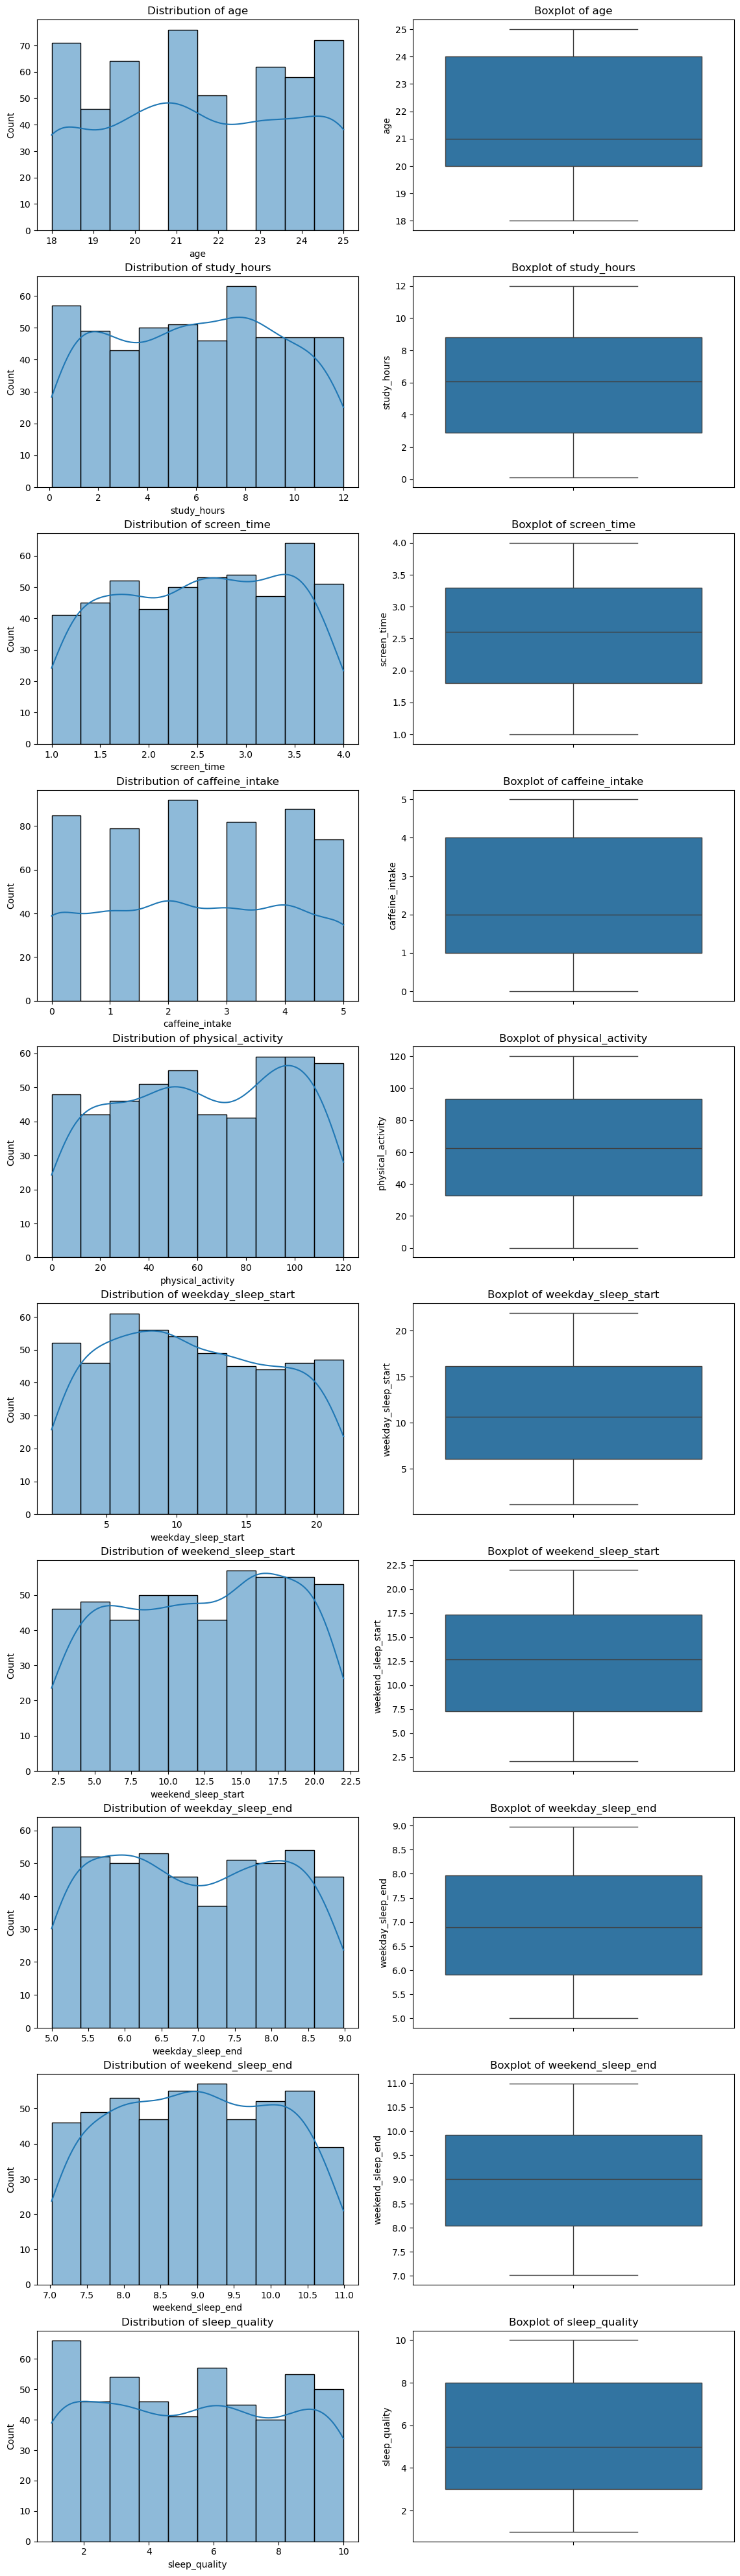

In [52]:
# histograms

# create a figure with subplots for all numerical columns
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, 4*len(numerical_columns)))
fig.tight_layout(pad=3.0)

# plot histograms and box plots for each numerical column
for idx, col in enumerate(numerical_columns):
    # histogram with KDE
    sns.histplot(data=data_main, x=col, kde=True, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Distribution of {col}')
    
    # box plot
    sns.boxplot(data=data_main, y=col, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Boxplot of {col}')

plt.show()

While the distribution is not already uniform, is also isn't a typically normal
one. Also, there are no outliers.
This makes normalization the better choice.

In [53]:
# create scaler
scaler = MinMaxScaler()

# get columns that need scaling (numerical ones except target)
cols_to_scale = [col for col in numerical_columns if col != 'sleep_quality']

# apply normalization
data_main[cols_to_scale] = scaler.fit_transform(data_main[cols_to_scale])

data_main

,age,study_hours,screen_time,caffeine_intake,physical_activity,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end,sleep_quality,gender_Female,gender_Male,gender_Other,university_year_1st Year,university_year_2nd Year,university_year_3rd Year,university_year_4th Year
0,0.857143,0.655462,0.800000,0.4,0.308333,0.627338,0.100251,0.605528,0.010076,10,False,False,True,False,True,False,False
1,0.428571,0.495798,0.300000,1.0,0.616667,0.366906,0.253133,0.806533,0.803526,2,False,True,False,True,False,False,False
2,0.571429,0.554622,0.966667,1.0,0.441667,0.907434,0.923308,0.472362,0.982368,5,False,True,False,False,False,False,True
3,0.857143,0.714286,0.600000,0.8,0.458333,0.898801,0.101754,0.424623,0.604534,9,False,False,True,False,False,False,True
4,0.285714,0.218487,0.566667,0.0,0.708333,0.954436,0.204010,1.000000,0.501259,3,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.857143,0.773109,0.300000,0.8,0.916667,0.783693,0.319799,0.484925,0.947103,4,False,True,False,False,True,False,False
496,0.285714,0.638655,0.833333,0.6,0.333333,0.006715,0.676190,0.213568,0.052897,4,False,True,False,False,True,False,False
497,0.428571,0.529412,0.966667,0.2,0.566667,0.424940,0.010025,0.115578,0.931990,10,False,True,False,False,False,True,False
498,0.000000,0.033613,0.833333,0.0,0.100000,0.864269,0.673684,0.841709,0.045340,2,True,False,False,False,True,False,False


## Join Data Sets